# Projek Akhir: Sistem Rekomendasi Buku menggunakan metode Content Based Filtering
Oleh Irfan Saputra Nst

## 1. Library Import
Pertama kita akan mengimport library" python yang kita akan gunakan dalam projek ini

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tabulate import tabulate

import zipfile
import os
from google.colab import files

## 1.1 Menyiapkan Kredensial Kaggle
Dataset yang kita gunakan dalam projek ini diambil dari sebuah website Kaggle. Daripada itu, sebelum mengunduh datanya, harus mengunggah kredensial berupa file JSON yang dapat di-generate melalui profile akun kagglenya langsung

In [2]:
# Meng-upload File kaggle.json
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 71 bytes


In [4]:
# Ubah Permission File
!chmod 600 /content/kaggle.json

In [5]:
# SetUp Kaggle Environment
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

## 1.2 Import Data
Disini kita akan mengimport data. Data sendiri saya ambil dari sebuah website kaggle. Berikut adalah informasi datasetnya:

Jenis | Keterangan
--- | ---
Title | Books Dataset
Source | [Kaggle](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset/data)
Maintainer | [Arasnhic](https://www.kaggle.com/arashnic)
License | [CC0: Public Domain](https://creativecommons.org/publicdomain/zero/1.0/)
Usability | 10.0


In [6]:
# Import Dataset
!kaggle datasets download -d arashnic/book-recommendation-dataset

Dataset URL: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset
License(s): CC0-1.0
 90% 22.0M/24.3M [00:01<00:00, 31.2MB/s]
100% 24.3M/24.3M [00:01<00:00, 21.2MB/s]


In [7]:
# Melakukan Ekstrak pada File Zip
local_zip = 'book-recommendation-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/book-recommendation')
zip_ref.close()

## 2 Data Understanding
Berikut adalah tahapan untuk memahami data:
1. Data Loading
2. Unvariate Exploratory Data Analysis
3. Data Prepocessing

## 2.1 Data Loading

Pada dataset ini terdiri dari 3 buah berkas csv diantaranya:
1. books.csv
2. ratings.csv
3. users.csv

Selanjutnya kita akan membaca/membuka dengan bantuan library pandas untuk melihat isi dari masing-masing berkas csv ini.

In [8]:
# Load Book Recommendation Dataset

books = pd.read_csv('book-recommendation/Books.csv')
ratings = pd.read_csv('book-recommendation/Ratings.csv')
users = pd.read_csv('book-recommendation/Users.csv')

<ipython-input-8-7fd90ca627c1>:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('book-recommendation/Books.csv')


### 2.1.1 Informasi File Dataset Books

Berikut adalah isi dari Books.csv

In [9]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


Dari output di atas dapat kita ketahui bahwa file **Books.csv** memuat 8 kolom sebagai berikut:

* ISBN: Berisi kode ISBN unik dari setiap buku.
* Book-Title: Judul lengkap dari buku.
* Book-Author: Nama penulis buku.
* Year-Of-Publication: Tahun terbit buku tersebut.
* Publisher: Nama penerbit buku.
* Image-URL-S: URL gambar buku dengan ukuran kecil.
* Image-URL-M: URL gambar buku dengan ukuran sedang.
* Image-URL-L: URL gambar buku dengan ukuran besar.

### 2.1.2 Informasi File Dataset Ratings

Berikut adalah isi dari Ratings.csv

In [10]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


Dari output di atas dapat kita ketahui bahwa file **Ratings.csv** memuat 3 kolom sebagai berikut:

* User-ID: berisi ID unik pengguna
* ISBN: berisi kode ISBN buku yang diberi rating oleh pengguna
* Book-Ratings: berisi nilai rating yang diberikan oleh pengguna berkisar antara 0-10

### 2.1.3 Informasi File Dataset Users

Berikut adalah isi dari Users.csv

In [11]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


Dari output di atas dapat kita ketahui bahwa file **Users.csv** memiliki 3 kolom sebagai berikut:

* User-ID: berisi ID unik pengguna
* Location: berisi data lokasi pengguna
* Age: berisi data usia pengguna

### 2.1.4 Jumlah Data Masing-Masing File Books-Recommendation-Dataset
Disini kita akan menggunakan rumus len dan unique untuk menjumlahkan data yang unik dari masing-masing file Books-Recommendation-Dataset



In [12]:
print('Jumlah data buku adalah: ', len(books.ISBN.unique()))
print('Jumlah data rating buku dari pembaca adalah: ', len(ratings.ISBN.unique()))
print('Jumlah data pengguna adalah: ', len(users['User-ID'].unique()))

Jumlah data buku adalah:  271360
Jumlah data rating buku dari pembaca adalah:  340556
Jumlah data pengguna adalah:  278858


Dari output dilihat bahwa jumlah data buku ada sekitar 271.360, lalu data rating buku dari pembaca sekitar 340.556, dan data penggunanya sendiri ada sekitar 278.858

## 3. Univariate Exploratory Data Analysis

Pada tahap ini, analisis dan eksplorasi akan dilakukan terhadap setiap variabel untuk memahami distribusi serta karakteristik masing-masing. Pemahaman ini penting guna menentukan pendekatan atau algoritma yang tepat untuk diterapkan pada data. Variabel-variabel dalam Book Recommendation Dataset adalah sebagai berikut:

* books: berisi informasi terkait buku.
* ratings: berisi penilaian atau peringkat yang diberikan pengguna kepada buku.
* users: berisi informasi mengenai pengguna, termasuk data demografis mereka.

Tujuannya adalah untuk mendapatkan wawasan yang lebih dalam mengenai setiap variabel sebelum melangkah ke tahap implementasi algoritma.

## 3.1 Variabel Books
Pertama-tama, kita akan memeriksa terlebih dahulu dari dataset variabel books dan mengecek informasi dari dataset fungsi info().

In [13]:
# Mengecek informasi dataset
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


Berdasarkan keluarannya, diketahui bahwa file books.csv memiliki 271.360 baris dan terdiri dari 8 kolom diantaranya:
* ISBN
* Book-Title
* Book-Author
* Year-Of-Publication
* Publisher
* Image-URL-S
* Image-URL-M
* Image-URL-L

Diketahui juga bahwa kolom dari 'Year-Of-Publication' merupakan daata object sedangkan tahun publikasi pada umumnya memiliki tipe data interger. Karena itu, dilakukan perbaikan tipe data terlebih dahulu.

Ketika kode dijalankan sebagai berikut:

```
books['Year-Of-Publication'].astype('int')
```
Terdapat error berupa ***Invalid literal for int() with base 10: 'DK Publishing Inc'***, yang artinya terdapat value pada 'Year-Of-Publication' ada yang bernilai 'DK Publishing Inc' Sepertinya ini terdapat kesalahan input, sehingga nanti akan dihapus nilai berupa teks tersebut sebelumnya mengubahnya ke dalam tipe data interger. Berdasarkan penelusurannya, terdapat 2 nilai teks yaitu 'DK Publishing Inc' dan 'Gallimard'


In [14]:
books[(books['Year-Of-Publication'] == 'DK Publishing Inc') | (books['Year-Of-Publication'] == 'Gallimard')]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


Menghapus value pada 'Year-Of-Publication' yang bernilai teks tersebut

In [15]:
temp = (books['Year-Of-Publication'] == 'DK Publishing Inc') | (books['Year-Of-Publication'] == 'Gallimard')
books = books.drop(books[temp].index)
books[(books['Year-Of-Publication'] == 'DK Publishing Inc') | (books['Year-Of-Publication'] == 'Gallimard')]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L


Setelah dihapus, selanjutnya kita akan mengubah tipe data pada 'Year-Of-Publication'

In [16]:
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)
print(books.dtypes)

ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication     int64
Publisher              object
Image-URL-S            object
Image-URL-M            object
Image-URL-L            object
dtype: object


Setelah mengubah tipe data **'Year-Of-Publication'** menjadi integer, langkah berikutnya adalah menghilangkan variabel yang tidak diperlukan dalam pengembangan model. Karena sistem rekomendasi yang akan dibuat adalah **Content-Based Filtering**, di mana rekomendasi didasarkan pada judul dan penulis buku yang pernah dibaca oleh pengguna, informasi seperti ukuran gambar tidak diperlukan. Oleh sebab itu, kolom **'Image-URL-S'**, **'Image-URL-M'**, dan **'Image-URL-L'** dapat dihapus karena tidak relevan untuk proses rekomendasi ini.

In [17]:
# Menghapus kolom Image-URL pada semua ukuran
books.drop(labels=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)

books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


Setelah dihapus kolom Image-URL. Sekarang dataset hanya tersisa 5 kolom saja. Untuk melihat berapa baris dari masing-masing variabel. Jalankan kode sebagai berikut:

In [18]:
print("Jumlah nomor ISBN Buku:", len(books['ISBN'].unique()))
print("Jumlah judul buku:", len(books['Book-Title'].unique()))
print('Jumlah penulis buku:', len(books['Book-Author'].unique()))
print('Jumlah Tahun Publikasi:', len(books['Year-Of-Publication'].unique()))
print('Jumlah nama penerbit:', len(books['Publisher'].unique()))

Jumlah nomor ISBN Buku: 271357
Jumlah judul buku: 242132
Jumlah penulis buku: 102021
Jumlah Tahun Publikasi: 116
Jumlah nama penerbit: 16805


Berdasarkan output di atas kita dapat lihat bahwa jumlah dari masing-masiing variabel. Perhatikan bahwa jumlah judul buku ada sekitar 242.132 sedangkan jumlah nomor ISBN ada sekitar 271.357 yang artinya ada beberapa buku yang tidak memiliki nomor ISBN, karena satu ISBN hanya boleh dimiliki oleh satu buku saja. Kasus ini nantinya dataset akan difilter lagi agar setiap buku dipastikan satu nomor ISBN saja.

Selanjutnya, melakukan distribusi data untuk melihat 10 nama penulist teratas berdasarkan jumlah buku

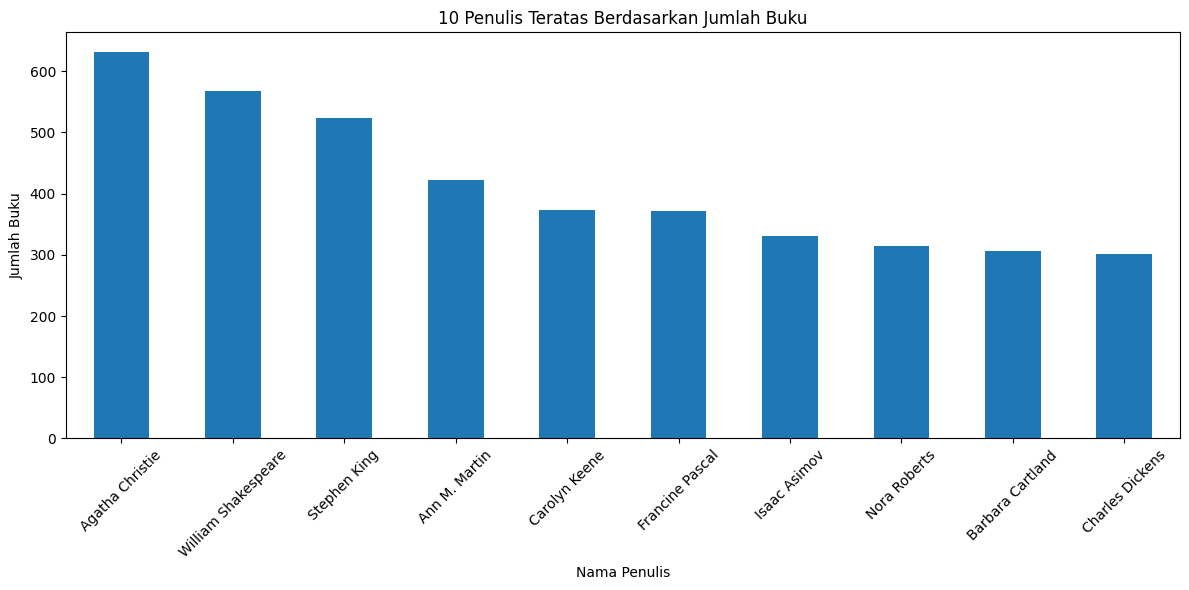

In [19]:
# Mengelompokkan data berdasarkan kolom 'Book-Author' dan menghitung jumlah buku yang ditulis oleh setiap penulis
author_counts = books.groupby('Book-Author')['Book-Title'].count()

# Mengurutkan penulis berdasarkan jumlah buku dalam urutan menurun
sorted_authors = author_counts.sort_values(ascending=False)

# Memilih 10 penulis teratas dengan jumlah buku terbanyak
top_10_authors = sorted_authors.head(10)

# Membuat plot batang untuk menampilkan 10 penulis teratas beserta jumlah buku yang ditulis oleh masing-masing penulis
plt.figure(figsize=(12, 6))  # Menentukan ukuran figure untuk plot
top_10_authors.plot(kind='bar')  # Membuat plot batang dari data penulis teratas
plt.xlabel('Nama Penulis')  # Menambahkan label untuk sumbu X
plt.ylabel('Jumlah Buku')  # Menambahkan label untuk sumbu Y
plt.title('10 Penulis Teratas Berdasarkan Jumlah Buku')  # Menambahkan judul plot
plt.xticks(rotation=45)  # Memutar label sumbu X agar lebih mudah dibaca
plt.tight_layout()  # Menyusun layout agar tidak ada bagian yang terpotong
plt.show()  # Menampilkan plot

Berdasarkan infomasi di atas, diketahui bahwa penulis dengan nama Agatha Christie menulis paling banyak buku yaitu sebanyak lebih dari 600 buku. Dari informasi ini juga diketahu dalam dataset terdapat beberapa nama penulis yang menulis buku lebih dari satu judul buku.

## 3.2 Ratings Variabel

Selanjutnya, eksplorasi dilakukan pada variabel ratings, yaitu penilaian yang diberikan oleh pembaca atau pengguna terhadap buku. Dataset ratings ini akan menjadi dasar untuk proses pengembangan model dengan metode collaborative filtering. Untuk memulai, kita bisa menggunakan fungsi info() untuk mendapatkan informasi detail mengenai variabel dalam dataset ratings, seperti tipe data dan jumlah nilai non-null pada setiap kolom.

In [20]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [21]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


Berdasarkan output yang dihasilkan, dataset ratings memiliki sebanyak 1.149.780 entri dan terdiri dari 3 kolom, yaitu:

* User-ID: Merupakan kode unik untuk setiap pengguna anonim yang memberikan rating.
* ISBN: Merupakan nomor identitas unik yang digunakan untuk setiap buku.
* Book-Rating: Merupakan penilaian atau rating yang diberikan oleh pengguna terhadap buku.

Untuk melihat jumlah entri dari masing-masing variabel, jalankan kode berikut:

In [22]:
# Menampilkan jumlah pengguna unik berdasarkan kolom 'User-ID'
print('Jumlah User-ID:', len(ratings['User-ID'].unique()))

# Menampilkan jumlah buku unik berdasarkan kolom 'ISBN'
print('Jumlah buku berdasarkan ISBN:', len(ratings['ISBN'].unique()))

# Menampilkan distribusi jumlah rating buku
print('Jumlah rating buku:')
sorted_ratings = ratings['Book-Rating'].value_counts().sort_index()

# Menampilkan tabel dengan distribusi rating dan jumlah masing-masing rating
pd.DataFrame({'Book-Rating': sorted_ratings.index, 'Jumlah': sorted_ratings.values})

Jumlah User-ID: 105283
Jumlah buku berdasarkan ISBN: 340556
Jumlah rating buku:


,Book-Rating,Jumlah
0,0,716109
1,1,1770
2,2,2759
3,3,5996
4,4,8904
5,5,50974
6,6,36924
7,7,76457
8,8,103736
9,9,67541


## 3.3 Users Variabel
Variabel terakhir yang akan dieksplorasi adalah users, yang berisi informasi tentang pengguna anonim beserta data demografisnya. Informasi ini penting untuk memahami profil pengguna yang memberikan rating pada buku. Untuk memulai eksplorasi, kita dapat menggunakan fungsi info() untuk melihat detail variabel, seperti tipe data, jumlah nilai non-null, dan lainnya.

In [23]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [24]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


Berdasarkan informasi di atas, dataset users memiliki 278.858 entri dan terdiri dari 3 variabel, yaitu:

* User-ID: Kode unik untuk setiap pengguna anonim.
* Location: Lokasi atau tempat tinggal pengguna.
* Age: Usia pengguna.

Dari data tersebut, diketahui bahwa beberapa pengguna tidak memiliki informasi usia. Meskipun data pengguna dapat berguna jika ingin mengembangkan sistem rekomendasi berbasis demografi atau kondisi sosial, pada studi kasus ini, data users tidak akan digunakan dalam model. Untuk pengembangan model rekomendasi yang akan dilakukan, hanya data books dan ratings yang akan dipakai. Ini berarti fokus pengembangan model adalah pada sistem rekomendasi berbasis konten dan rating, tanpa mempertimbangkan faktor demografi.

## 4. Data Preprocessing
Seperti yang telah dijelaskan pada tahap data understanding, folder Book Recommendation Dataset terdiri dari tiga file terpisah, yaitu books, ratings, dan users. Pada tahap ini, akan dilakukan proses penggabungan ketiga file tersebut menjadi satu kesatuan file untuk memudahkan pengembangan model rekomendasi.

Namun, karena pada model yang akan dibuat hanya menggunakan data dari books dan ratings, kita hanya akan menggabungkan kedua file ini. Proses penggabungan akan dilakukan berdasarkan kolom ISBN yang ada di kedua file, sehingga setiap buku yang diberi rating akan memiliki informasi tambahan seperti judul buku dan penulis.

## 4.1 Merge File & Check Jumlah Rating
Pada tahap ini dilakukan merge file books dan ratings untuk mengetahui jumlah seluruh rating dari berbagai file tersebut.

In [25]:
# Merge dataframe ratings dengan books berdasarkan nilai ISBN
books = pd.merge(ratings, books, on='ISBN', how='left')
books

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001.0,Heinle
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996.0,Warner Books
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001.0,Cambridge University Press
...,...,...,...,...,...,...,...
1149775,276704,1563526298,9,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,2000.0,Longstreet Press
1149776,276706,0679447156,0,Eight Weeks to Optimum Health: A Proven Progra...,Andrew Weil,1997.0,Alfred A. Knopf
1149777,276709,0515107662,10,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996.0,Jove Books
1149778,276721,0590442449,10,Fourth Grade Rats,Jerry Spinelli,1996.0,Scholastic


Setelah dilakukan penggabungan, dataset yang dihasilkan memiliki 7 variabel dengan 1.149.780 baris data. Output sebelumnya hanya menampilkan beberapa baris awal dan akhir dari dataset gabungan. Dataset inilah yang akan digunakan dalam pembuatan sistem rekomendasi.

Untuk langkah selanjutnya, kita akan melakukan perhitungan jumlah rating yang diberikan kepada setiap buku berdasarkan kolom ISBN. Berikut adalah kode yang dapat digunakan untuk menghitung jumlah rating berdasarkan ISBN:

In [26]:
books.groupby('ISBN').sum()

,User-ID,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
ISBN,,,,,,
0330299891,271009,6,0,0,0.0,0
0375404120,356057,3,0,0,0.0,0
0586045007,89192,0,0,0,0.0,0
9022906116,100868,7,0,0,0.0,0
9032803328,89192,0,0,0,0.0,0
...,...,...,...,...,...,...
cn113107,107301,0,0,0,0.0,0
ooo7156103,266146,7,0,0,0.0,0
§423350229,85250,0,0,0,0.0,0


## 5. Data Prepation - Model Content Based Filtering

Pada tahap ini, beberapa teknik akan diterapkan untuk mempersiapkan data agar siap digunakan dalam pengembangan sistem rekomendasi berbasis konten (content-based filtering). Berikut adalah teknik yang akan dilakukan:

* Menghilangkan Missing Value: Untuk memastikan bahwa data yang digunakan dalam model lengkap dan valid, kita perlu menghapus baris-baris yang mengandung missing value (nilai yang hilang). Hal ini penting untuk mencegah kesalahan saat pelatihan model.

* Menyamakan Jenis Buku Berdasarkan ISBN: Pada sistem rekomendasi berbasis konten, setiap buku harus memiliki ISBN yang unik, di mana satu nomor ISBN mewakili satu judul buku. Oleh karena itu, kita perlu memastikan tidak ada duplikasi ISBN dan semua ISBN sudah dipetakan dengan benar ke judul buku yang sesuai.


## 5.1 Mengatasi Missing Value

Setelah proses penggabungan file selesai, langkah berikutnya adalah melakukan pengecekan apakah terdapat missing value (nilai yang hilang) di dalam dataset. Proses ini penting untuk memastikan data yang akan digunakan dalam pelatihan model lengkap dan valid.

In [27]:
# Mengecek missing value dengan fungsi isnull()
books.isnull().sum()

,0
User-ID,0
ISBN,0
Book-Rating,0
Book-Title,118648
Book-Author,118650
Year-Of-Publication,118648
Publisher,118650


Karena jumlah missing value terbesar berada pada fitur 'Publisher' sebesar 118.650 dari total dataset 1.149.780 baris, yang dianggap tidak signifikan, maka kita dapat menghapus baris-baris yang memiliki missing value tersebut. Untuk kasus ini, kita akan melakukan proses drop atau penghapusan missing value dan menyimpan hasilnya dalam variabel baru bernama all_books_clean.

In [28]:
all_books_clean = books.dropna()
all_books_clean

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001.0,Heinle
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996.0,Warner Books
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001.0,Cambridge University Press
...,...,...,...,...,...,...,...
1149774,276704,0876044011,0,Edgar Cayce on the Akashic Records: The Book o...,Kevin J. Todeschi,1998.0,A.R.E. Press (Association of Research &amp; Enlig
1149775,276704,1563526298,9,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,2000.0,Longstreet Press
1149776,276706,0679447156,0,Eight Weeks to Optimum Health: A Proven Progra...,Andrew Weil,1997.0,Alfred A. Knopf
1149777,276709,0515107662,10,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996.0,Jove Books


Sekarang dataset terdiri dari 1.031.129 baris. Untuk memastikan tidak ada missing value lagi dalam data, jalan kode berikut:

In [29]:
all_books_clean.isnull().sum()

,0
User-ID,0
ISBN,0
Book-Rating,0
Book-Title,0
Book-Author,0
Year-Of-Publication,0
Publisher,0


Sekarang dataset sudah bersih dan bisa lanjut ke tahap berikutnya

## 5.2 Menyamakan Jenis Buku berdasarkan ISBN

Sebelum masuk ke tahap pemodelan, kita perlu memastikan bahwa setiap ISBN hanya terkait dengan satu judul buku. Jika ada ISBN yang terkait dengan lebih dari satu judul, hal tersebut dapat menyebabkan bias pada data rekomendasi. Oleh karena itu, kita harus memastikan bahwa setiap ISBN unik hanya terkait dengan satu judul buku.

Langkah pertama adalah melakukan pengecekan ulang terhadap data setelah proses cleaning sebelumnya. Setelah itu, kita akan membuat variabel baru bernama final_books untuk menyimpan dataframe hasil pengecekan dan perbaikan.

In [30]:
# Mengurutkan buku berdasarkan ISBN dalam urutan naik
final_books = all_books_clean.sort_values('ISBN', ascending=True)

# Menampilkan beberapa baris pertama dari dataset final_books yang telah diurutkan
final_books.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
703628,171118,0000913154,8,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967.0,Simon &amp; Schuster
357256,86123,0001010565,0,Mog's Christmas,Judith Kerr,1992.0,Collins
866078,209516,0001010565,0,Mog's Christmas,Judith Kerr,1992.0,Collins
103677,23902,0001046438,9,Liar,Stephen Fry,0.0,Harpercollins Uk
807953,196149,0001046713,0,Twopence to Cross the Mersey,Helen Forrester,1992.0,HarperCollins Publishers


Terdapat 1.031.129 baris data. Untuk mengecek berapa jumlah nomor ISBN yang mencakup data tersebut. Jalankan kode ini

In [31]:
# Mengecek berapa jumlah final_books
len(final_books['ISBN'].unique())

270144

Selanjutnya, mengecek jumlah judul buku dengan kode berikut:

In [32]:
len(final_books['Book-Title'].unique())

241065

Untuk memastikan bahwa setiap ISBN hanya terkait dengan satu judul buku, kita perlu membuang data duplikat pada kolom 'ISBN'. Setelah itu, kita akan menyimpan dataset yang telah dibersihkan ke dalam variabel baru bernama 'preparation'.

Berikut adalah kode untuk menghapus duplikat dan membuat dataset yang unik berdasarkan ISBN:

In [33]:
preparation = final_books.drop_duplicates('ISBN')
preparation

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
703628,171118,0000913154,8,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967.0,Simon &amp; Schuster
357256,86123,0001010565,0,Mog's Christmas,Judith Kerr,1992.0,Collins
103677,23902,0001046438,9,Liar,Stephen Fry,0.0,Harpercollins Uk
807953,196149,0001046713,0,Twopence to Cross the Mersey,Helen Forrester,1992.0,HarperCollins Publishers
103678,23902,000104687X,6,"T.S. Eliot Reading \The Wasteland\"" and Other ...",T.S. Eliot,1993.0,HarperCollins Publishers
...,...,...,...,...,...,...,...
1100731,264317,B000234N76,0,Falling Angels,Tracy Chevalier,2001.0,E P Dutton
423108,100906,B000234NC6,0,It Must've Been Something I Ate: The Return of...,Jeffrey Steingarten,2002.0,Knopf
419279,100088,B00029DGGO,0,"Good Wife Strikes Back, The",Elizabeth Buchan,0.0,Viking Adult
743545,179791,B0002JV9PY,0,The Blockade Runners,Jules Verne,0.0,Digireads.com


Berikut adalah langkah-langkah untuk melakukan pengecekan kembali jumlah data dari ISBN, judul buku (Book-Title), dan nama penulis buku (Book-Author), serta mengonversi data dari tipe Series menjadi list menggunakan fungsi tolist():

In [34]:
# Mengonversi kolom 'ISBN' dari Series menjadi list
isbn_id = preparation['ISBN'].tolist()

# Mengonversi kolom 'Book-Title' dari Series menjadi list
book_title = preparation['Book-Title'].tolist()

# Mengonversi kolom 'Book-Author' dari Series menjadi list
book_author = preparation['Book-Author'].tolist()

# Mengonversi kolom 'Year-Of-Publication' dari Series menjadi list
year_of_publication = preparation['Year-Of-Publication'].tolist()

# Mengonversi kolom 'Publisher' dari Series menjadi list
publisher = preparation['Publisher'].tolist()

# Menampilkan jumlah elemen dalam list 'isbn_id', 'book_title', 'book_author', 'year_of_publication', dan 'publisher'
print(len(isbn_id))
print(len(book_title))
print(len(book_author))
print(len(year_of_publication))
print(len(publisher))


270144
270144
270144
270144
270144


Berdasarkan output sebelumnya, jumlah data dari ISBN, judul buku, nama penulis buku, tahun publikasi, dan nama penerbit telah disamakan dan dataset kini tersisa 270.144 baris setelah proses penghilangan duplikasi nilai. Langkah berikutnya adalah membuat dictionary untuk menentukan pasangan key-value dari isbn_id, book_title, book_author, year_of_publication, dan publisher yang telah dipersiapkan sebelumnya. Dictionary ini akan digunakan dalam proses pengembangan model sistem rekomendasi berbasis konten (content-based filtering).

In [35]:
# Membuat dataframe baru dengan kolom 'isbn_id', 'book_title', 'book_author', 'year_of_publication', dan 'publisher'
books_new = pd.DataFrame({
    'isbn': isbn_id,
    'book_title': book_title,
    'book_author': book_author,
    'year_of_publication': year_of_publication,
    'publisher': publisher
})

# Menampilkan dataframe 'books_new'
books_new

,isbn,book_title,book_author,year_of_publication,publisher
0,0000913154,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967.0,Simon &amp; Schuster
1,0001010565,Mog's Christmas,Judith Kerr,1992.0,Collins
2,0001046438,Liar,Stephen Fry,0.0,Harpercollins Uk
3,0001046713,Twopence to Cross the Mersey,Helen Forrester,1992.0,HarperCollins Publishers
4,000104687X,"T.S. Eliot Reading \The Wasteland\"" and Other ...",T.S. Eliot,1993.0,HarperCollins Publishers
...,...,...,...,...,...
270139,B000234N76,Falling Angels,Tracy Chevalier,2001.0,E P Dutton
270140,B000234NC6,It Must've Been Something I Ate: The Return of...,Jeffrey Steingarten,2002.0,Knopf
270141,B00029DGGO,"Good Wife Strikes Back, The",Elizabeth Buchan,0.0,Viking Adult
270142,B0002JV9PY,The Blockade Runners,Jules Verne,0.0,Digireads.com


Karena dataset yang dimiliki sangat besar dan dapat mengakibatkan penggunaan memori yang tinggi selama proses pengembangan model, proyek ini akan membatasi penggunaan data dengan hanya mengambil baris dari data pertama hingga baris ke-20.000 (tidak termasuk baris ke-20.000).

In [36]:
books_new = books_new[:20000]
books_new

,isbn,book_title,book_author,year_of_publication,publisher
0,0000913154,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967.0,Simon &amp; Schuster
1,0001010565,Mog's Christmas,Judith Kerr,1992.0,Collins
2,0001046438,Liar,Stephen Fry,0.0,Harpercollins Uk
3,0001046713,Twopence to Cross the Mersey,Helen Forrester,1992.0,HarperCollins Publishers
4,000104687X,"T.S. Eliot Reading \The Wasteland\"" and Other ...",T.S. Eliot,1993.0,HarperCollins Publishers
...,...,...,...,...,...
19995,0140444696,The Kreutzer Sonata and Other Stories (Penguin...,Leo Tolstoy,1986.0,Penguin Books
19996,014044470X,The Fiancee and Other Stories (Penguin Classics),Anton Pavlovich Chekhov,1986.0,Penguin Books
19997,0140444726,Jacques the Fatalist and His Master (Penguin C...,Denis Diderot,1986.0,Penguin Books
19998,0140444742,Seven Viking Romances (Penguin Classics),Hermann Palsson,1986.0,Penguin Books


## 6. Model Development dengan Content Based Filtering

Pada tahap ini, akan dikembangkan model menggunakan teknik **Content-Based Filtering**. Content-Based Filtering adalah pendekatan dalam sistem rekomendasi yang memanfaatkan informasi atau "konten" dari item atau pengguna untuk membuat rekomendasi. Prinsip dasarnya adalah mencocokkan preferensi pengguna dengan karakteristik atau konten dari item yang telah dilihat atau disukai sebelumnya. Misalnya, jika seorang pengguna menyukai atau pernah membeli buku dengan judul "Introduction to Machine Learning" yang ditulis oleh "Alex Smola", maka sistem akan mencari buku lain dengan fitur serupa dan merekomendasikannya sebagai rekomendasi teratas kepada pengguna tersebut.

Dalam pengembangan model ini, representasi fitur penting dari setiap judul buku akan dicari menggunakan **TF-IDF (Term Frequency - Inverse Document Frequency) Vectorizer**. TF-IDF Vectorizer adalah alat untuk mengonversi dokumen teks menjadi representasi vektor berdasarkan nilai TF-IDF setiap kata dalam dokumen tersebut. TF (Term Frequency) mengukur frekuensi kemunculan suatu kata dalam dokumen, sementara IDF (Inverse Document Frequency) mengukur seberapa unik atau jarang kata tersebut muncul dalam seluruh koleksi dokumen. Vektor ini akan digunakan untuk menemukan fitur penting dari setiap judul buku berdasarkan nama penulis buku dalam model Content-Based Filtering yang dikembangkan. Fungsi `TfidfVectorizer()` dari library Sklearn akan digunakan untuk tujuan ini.

Untuk menghitung derajat kesamaan (similarity degree) antar judul buku, akan digunakan teknik **cosine similarity**. Metode ini mengukur kesamaan antar dua vektor dalam ruang berdimensi banyak dengan mengukur sudut kosinus antara kedua vektor tersebut. Semakin kecil sudutnya, semakin besar kesamaan antara vektor-vektor tersebut. Fungsi `cosine_similarity` dari library Sklearn akan digunakan untuk menghitung kesamaan ini.

Sebelum memulai pengembangan model dengan Content-Based Filtering, lakukan pengecekan kembali dataset dan tetapkan dataframe dari tahap sebelumnya ke dalam variabel **data**.

In [37]:
content_based_filter = books_new
content_based_filter.sample(5)

,isbn,book_title,book_author,year_of_publication,publisher
14752,0138242771,Spain&amp;Moroc $40day,Haggart,1989.0,Prentice Hall
6829,0060904453,The Thurber Carnival (Harper Colophon Books),James Thurber,1975.0,HarperCollins
10629,006250732X,Evolution's End : Claiming the Potential of Ou...,Joseph C. Pearce,1993.0,HarperSanFrancisco
7894,0060959533,Test Pattern,Marjorie Klein,2001.0,Perennial
18736,014032951X,The Rabbi's Girls,Johanna Hurwitz,1989.0,Penguin USA


## **6.1 TF-IDF Vectorizer**

Import library fungsi tfidvectorizer() dari library sklearn

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inisialisasi objek TfidfVectorizer
tf = TfidfVectorizer()

# Melakukan perhitungan IDF pada content_based_filter 'book_author'
tf.fit(content_based_filter['book_author'])

# Mendapatkan nama fitur dari indeks integer
tf.get_feature_names_out()

array(['1988', 'aaron', 'aarons', ..., 'zweifel', 'zwinger', 'â¼nter'],
      dtype=object)

Selanjutnya, lakukan fit dan transformasi ke dalam bentuk matriks

In [39]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(content_based_filter['book_author'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(20000, 8746)

Berdasarkan output, matriks memiliki ukuran **(20.000, 8.746)**, di mana **20.000** mewakili jumlah data dan **8.746** merupakan jumlah fitur nama penulis buku. Untuk menghasilkan vektor TF-IDF dalam bentuk matriks, gunakan fungsi `todense()`.

In [40]:
# Mengubah vektor TF-IDF menjadi bentuk matriks menggunakan fungsi todense()
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

Selanjutnya, kita akan menampilkan matriks TF-IDF dalam bentuk DataFrame, di mana kolom akan diisi dengan nama penulis buku dan baris akan diisi dengan judul buku.

In [41]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=content_based_filter.book_title
).sample(15, axis=1).sample(10, axis=0)

,sarna,gutman,patchett,bix,laurent,adoff,hatto,garcia,harbison,garvin,masini,scharf,guinness,sender,narayan
book_title,,,,,,,,,,,,,,,
Informix On-Line Performance Tuning,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Lives of a Cell: Notes of a Biology Watcher,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Complete Idiots Guide to Cruise Vacations,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
World Cup USA '94: The Complete Guide to Soccer's World Cup and All 24 Teams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Unwanted Company,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lipshtick,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Twist in the Tale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
How to Be Yourself,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Different Dragons (Young Puffin),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Output dari matriks TF-IDF berhasil menunjukkan representasi fitur penting dari setiap kategori judul buku menggunakan fungsi `TfidfVectorizer`. Dalam kasus ini, dataset hanya menampilkan sampel data, sehingga keseluruhan matriks tidak terlihat. Dari total 20.000 data, hanya dipilih sampel acak yang terdiri dari 10 judul buku pada baris vertikal dan 15 nama penulis buku pada baris horizontal.

## **6.2 Cosine Similarity**

Pada tahap sebelumnya, kita telah berhasil mengidentifikasi korelasi antara judul buku dengan penulis buku. Sekarang, kita akan menghitung derajat kesamaan (similarity degree) antar judul buku menggunakan teknik cosine similarity.

In [42]:
from sklearn.metrics.pairwise import cosine_similarity

# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Pada tahap ini, kita akan menghitung cosine similarity dari DataFrame `tfidf_matrix` yang diperoleh sebelumnya. Dengan menggunakan fungsi `cosine_similarity` dari library `sklearn`, kita akan mendapatkan nilai kesamaan (similarity) antar judul buku. Kode di atas akan menghasilkan matriks kesamaan dalam bentuk array.

Selanjutnya, kita akan menampilkan matriks kesamaan dengan menampilkan nama judul buku pada 5 sampel kolom (axis = 1) dan 10 sampel baris (axis = 0).

In [43]:
# Membuat DataFrame dari variabel cosine_sim dengan baris dan kolom berupa nama judul buku
cosine_sim_df = pd.DataFrame(cosine_sim, index=content_based_filter['book_title'], columns=content_based_filter['book_title'])
print('Shape:', cosine_sim_df.shape)

# Menampilkan matriks kesamaan untuk beberapa judul buku
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (20000, 20000)


book_title,The Poisonwood Bible,The Death of the Heart (Penguin Classics),Less Than Angels,Nashville 1864: The Dying of the Light,Â¡Trato hecho!: Spanish For Real Life (2nd Edition)
book_title,,,,,
Instead of Three Wishes: Magical Short Stories (Puffin Short Stories),0.0,0.0,0.0,0.0,0.0
Sir Thomas Wyatt: The Complete Poems (Penguin Classics),0.0,0.0,0.0,0.0,0.0
Close to Home: A Novel of Suspense,0.0,0.0,0.0,0.0,0.0
The Horse in Harry's Room (Level 1),0.0,0.0,0.0,0.0,0.0
The Actor's Book of Monologues for Women: From Non-Dramatic Sources,0.0,0.0,0.0,0.0,0.0
Coming Through Slaughter,0.0,0.0,0.0,0.0,0.0
The Path to Power,0.0,0.0,0.0,0.0,0.0
The Ralph Mouse Collection (Cleary Reissue),0.0,0.0,0.0,0.0,0.0
Plain Seeing: A Novel,0.0,0.0,0.0,0.0,0.0


Dengan menggunakan cosine similarity, kita berhasil mengidentifikasi tingkat kesamaan antara satu judul buku dengan judul buku lainnya. Matriks kesamaan memiliki ukuran (20000, 20000), yang menunjukkan bahwa matriks ini mencakup 20.000 judul buku baik pada sumbu X maupun Y. Ini berarti kita telah mengidentifikasi tingkat kesamaan untuk seluruh 20.000 judul buku. Namun, karena ukuran matriks yang sangat besar, kita tidak dapat menampilkan seluruh data sekaligus. Oleh karena itu, hanya 10 judul buku pada baris vertikal dan 5 judul buku pada baris horizontal yang ditampilkan sebagai sampel. Dengan data kesamaan yang diperoleh, langkah berikutnya adalah merekomendasikan daftar judul buku yang mirip dengan judul buku yang sebelumnya pernah dibeli atau dibaca oleh pengguna.

## 6.3 Implementasi Rekomendasi
Pada tahap ini, kita akan membuat sebuah fungsi bernama `book_recommendations` dengan parameter-parameter berikut:

- **`book_title`**: Nama judul buku yang menjadi referensi untuk rekomendasi (index kemiripan dataframe).
- **`similarity_data`**: DataFrame yang berisi informasi kemiripan antar judul buku, yang telah didefinisikan sebelumnya.
- **`items`**: Nama dan fitur yang digunakan untuk mendefinisikan kemiripan, dalam hal ini adalah `book_title` dan `book_author`.
- **`k`**: Jumlah top-N rekomendasi yang akan diberikan oleh sistem rekomendasi, dengan nilai default 5.

Fungsi ini akan memberikan sejumlah rekomendasi judul buku berdasarkan kemiripan dengan judul buku yang diberikan. Output dari sistem rekomendasi adalah daftar top-N rekomendasi, diatur oleh parameter `k`.

Sebelum menulis kode, penting untuk diingat bahwa sistem rekomendasi harus memberikan output dalam bentuk top-N rekomendasi, sehingga parameter `k` akan digunakan untuk menentukan jumlah rekomendasi yang diberikan kepada pengguna.

In [44]:
def book_recommendation(book_title, similarity_data=cosine_sim_df, items=content_based_filter[['book_title', 'book_author']], k=5):
    # Mengambil data kemiripan untuk judul buku yang diberikan dan mengubahnya menjadi numpy array
    # Argpartition digunakan untuk mendapatkan index dari kemiripan tertinggi
    index = similarity_data.loc[:, book_title].to_numpy().argpartition(range(-1, -k, -1))

    # Mengambil nama-nama judul buku dengan kemiripan terbesar
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop book_title dari daftar rekomendasi agar tidak muncul sebagai rekomendasi
    closest = closest.drop(book_title, errors='ignore')

    # Menggabungkan dengan informasi fitur buku dan mengembalikan hasil rekomendasi
    return pd.DataFrame(closest).merge(items).head(k)

Untuk mendapatkan rekomendasi 5 buku teratas menggunakan sistem, pertama-tama kita akan menggunakan fungsi `argpartition` untuk menemukan sejumlah nilai tertinggi (dalam hal ini: k tertinggi) dari tingkat kemiripan (similarity) antara buku-buku, yang terdapat dalam dataframe `cosine_sim_df`. Setelah itu, kita akan mengurutkan data ini berdasarkan bobot atau tingkat kesamaan dari yang tertinggi ke terendah, dan hasilnya akan disimpan dalam variabel `closest`.

Selanjutnya, kita perlu menghapus judul buku yang sedang dicari (yang dimasukkan dalam variabel `book_title`) dari daftar rekomendasi, agar judul buku tersebut tidak muncul dalam hasil rekomendasi. Ini dilakukan karena tujuan dari fungsi ini adalah untuk mencari judul buku lain yang mirip dengan judul buku yang diberikan sebagai input.

Dengan cara ini, fungsi `book_recommendation` akan menghasilkan rekomendasi 5 buku teratas yang paling mirip dengan judul buku yang diinput oleh pengguna.

In [47]:
book_title_test ="Close to Home: A Novel of Suspense"

content_based_filter[content_based_filter.book_title.eq(book_title_test)]

,isbn,book_title,book_author,year_of_publication,publisher
8991,0061031097,Close to Home: A Novel of Suspense,Peter Robinson,2004.0,Avon Books


Perhatikan, bahwa judul buku 'Close to Home: A Novel of Suspense' ditulis oleh Peter Robinson. Sekarang, gunakan fungsi book_recommendation untuk

---

mendapatkan rekomendasi berdasarkan judul buku tersebut.

In [48]:
# Mendapatkan rekomendasi judul buku yang mirip
book_recommendation(book_title_test)

,book_title,book_author
0,How Ronald Reagan Changed My Life,Peter Robinson
1,Playing with Fire : A Novel of Suspense (Robin...,Peter Robinson
2,Close to Home : A Novel of Suspense,Peter Robinson
3,A Dedicated Man: An Inspector Banks Mystery,Peter Robinson
4,Past Reason Hated,Peter Robinson


Berdasarkan output diatas, sistem berhasil merekomendasikan 5 judul buku teratas dengan kategori nama penulis (book_author) yaitu 'Thomas Merton'.

## 7. Evaluasi
## 7.1 Evaluasi Model Content Based Filtering

Pada proyek ini, metrik evaluasi yang digunakan untuk mengukur kinerja model dengan content-based filtering adalah Precision, Recall, dan F1-Score, yang merupakan metrik standar untuk evaluasi model.

- **Precision** mengukur rasio item relevan yang direkomendasikan oleh model terhadap total item yang direkomendasikan.
- **Recall** mengukur rasio item relevan yang direkomendasikan oleh model terhadap total item yang seharusnya direkomendasikan.
- **F1-Score** adalah kombinasi dari Precision dan Recall, yang memberikan nilai tunggal untuk mengukur keseimbangan antara keduanya.

Sebelum menghitung metrik evaluasi seperti precision, recall, dan f1-score, diperlukan data yang berisi label sebenarnya (ground truth) untuk menilai hasil prediksi model. Pada proyek ini, data ground truth dibuat berdasarkan derajat kesamaan (similarity) yang dihitung dengan teknik cosine similarity. Dalam data ini, setiap baris dan kolom mewakili judul buku, dan setiap nilai di dalam sel merepresentasikan label: 1 untuk 'similar' (mirip) dan 0 untuk 'not similar' (tidak mirip).

Selain itu, perlu ditetapkan nilai ambang batas (threshold) yang menentukan apakah nilai kesamaan antara dua item dianggap 1 (similar) atau 0 (not similar).

In [49]:
# Menentukan threshold untuk mengkategorikan similarity sebagai 1 atau 0
threshold = 0.5

# Membuat ground truth data dengan asumsi threshold
ground_truth = np.where(cosine_sim >= threshold, 1, 0)

# Menampilkan beberapa nilai pada ground truth matrix
ground_truth_df = pd.DataFrame(ground_truth, index=content_based_filter['book_title'], columns=content_based_filter['book_title']).sample(5, axis=1).sample(10, axis=0)

Pada kode di atas, threshold atau nilai ambang batas ditetapkan sebesar 0.5. Nilai threshold ini dipilih berdasarkan kebutuhan dan karakteristik model setelah mengevaluasi hasil rekomendasi sebelumnya. Selanjutnya, matriks ground truth dibuat menggunakan fungsi `np.where()` dari NumPy. Matriks ini akan berisi nilai 1 di posisi di mana cosine similarity antara dua item sama atau lebih besar dari threshold, dan nilai 0 untuk posisi di mana similarity di bawah threshold. Setelah matriks ground truth dibuat, hasilnya disajikan dalam bentuk DataFrame, dengan baris dan kolom yang diindeks menggunakan judul buku dari dataset. Berikut adalah tampilan dari DataFrame ground truth.

In [50]:
ground_truth_df

book_title,Message from Forever,Always the Bridesmaid,The Road to Wellville,Boys on the Brain,As the Crow Flies
book_title,,,,,
mental_floss Presents Condensed Knowledge: A Deliciously Irreverent Guide to Feeling Smart Again,0,0,0,0,0
The Art of Meditation,0,0,0,0,0
The Phantom of the Opera: Pop-Up Book,0,0,0,0,0
Cram Course for the Gre (Gre Cram Course),0,0,0,0,0
Travels in Mauritania,0,0,0,0,0
Greek Myths (Pelican S.),0,0,0,0,0
Edge (Novel),0,0,0,0,0
Social Usage,0,0,0,0,0
Nine and Counting: The Women of the Senate,0,0,0,0,0


Setelah matriks ground truth yang berisi label sebenarnya dari hasil cosine similarity dibuat, langkah selanjutnya adalah menghitung evaluasi model menggunakan metrik precision, recall, dan f1-score. Untuk itu, kita perlu mengimpor fungsi `precision_recall_fscore_support` dari library Sklearn, yang digunakan untuk menghitung ketiga metrik tersebut.

Karena keterbatasan memori pada perangkat, hanya diambil sekitar 10.000 sampel dari matriks cosine similarity dan matriks ground truth. Hal ini dilakukan untuk mempercepat proses perhitungan, mengingat ukuran matriks yang besar. Matriks cosine similarity dan ground truth kemudian dikonversi menjadi array satu dimensi untuk memudahkan perbandingan dan perhitungan metrik evaluasi.

Threshold digunakan untuk mengklasifikasikan nilai cosine similarity menjadi 1 atau 0. Jika nilai similarity sama atau lebih besar dari threshold, maka dianggap sebagai 1 (positif), dan jika kurang, dianggap sebagai 0 (negatif). Hasil klasifikasi ini disimpan dalam array `predictions`.

Terakhir, fungsi `precision_recall_fscore_support` digunakan untuk menghitung nilai precision, recall, dan f1-score. Parameter `average='binary'` digunakan karena evaluasi dilakukan dalam konteks klasifikasi biner (1 atau 0), dan `zero_division=1` digunakan untuk menghindari kesalahan pembagian dengan nol jika ada kelas yang tidak muncul dalam prediksi. Implementasi kode ini adalah sebagai berikut:

In [51]:
from sklearn.metrics import precision_recall_fscore_support

# Mengambil sebagian kecil dari cosine similarity matrix dan ground truth matrix
sample_size = 10000
cosine_sim_sample = cosine_sim[:sample_size, :sample_size]
ground_truth_sample = ground_truth[:sample_size, :sample_size]

# Mengonversi cosine similarity matrix menjadi array satu dimensi untuk perbandingan
cosine_sim_flat = cosine_sim_sample.flatten()

# Mengonversi ground truth matrix menjadi array satu dimensi
ground_truth_flat = ground_truth_sample.flatten()

# Menghitung metrik evaluasi
predictions = (cosine_sim_flat >= threshold).astype(int)
precision, recall, f1, _ = precision_recall_fscore_support(
    ground_truth_flat, predictions, average='binary', zero_division=1
)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 1.0
Recall: 1.0
F1-score: 1.0


Berdasarkan hasil evaluasi, diperoleh nilai untuk masing-masing metrik evaluasi: precision, recall, dan F1 score. Nilai precision mencapai 1.0, yang berarti semua prediksi positif yang dibuat oleh model adalah benar, tanpa adanya false positive. Nilai recall juga sebesar 1.0, menunjukkan bahwa model berhasil mengidentifikasi 100% item yang sebenarnya relevan. Nilai F1 score, yang juga sekitar 1.0, menunjukkan keseimbangan yang sempurna antara precision dan recall, menandakan bahwa model memberikan hasil yang sangat baik untuk kedua kelas (positif dan negatif).

Kesimpulannya, berdasarkan hasil dari metrik evaluasi ini, model bekerja dengan sangat baik dalam memberikan rekomendasi item menggunakan content-based filtering.